# Setup
This script contains the EDA and modeling for predicting the amount of residential solar systems across the US. 

In [1]:
#Import Python libraries
from sklearn.model_selection import train_test_split,\
StratifiedKFold,\
RandomizedSearchCV,\
GridSearchCV
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

#actually used in this script
#Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
import tensorflow as tf
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import scipy
from tensorflow import keras
import shap
from IPython.core.interactiveshell import InteractiveShell

#Set options for notebook display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
InteractiveShell.ast_node_interactivity = 'all'

#Set seed for reproducability
seed = 111

In [2]:
#Define functions
def find_na_columns(df: pd.DataFrame):
    """
    Function to list columns that contain n/a's
    Input: df: pd.DataFrame
    Output: List of column names
    """
    na_cols = []
    for col in df:
        if df[col].isna().any():
            na_cols.append(col)
    return(na_cols)

#Imputation
def impute_values(train_df: pd.DataFrame, test_df: pd.DataFrame, column: str, group_column: str,  impute_value='mean'):
    """
    Function to impute missing values for numeric variables. Group column used to make imputations by mean more accurate.
    Input: train_df: pd.DataFrame, train data
            test_df: pd.DataFrame, test data
            column: str, column to impute
            group_column: str, column to group by for imputing
            impute_value: str ('mean', 'median')
    Output: dataframe with column with all missing values imputed to impute value
    """
    if impute_value == 'mean':
        subset = train_df[[column,group_column]].groupby(group_column).mean()
    elif impute_value == 'median':
        subset = train_df[[column,group_column]].groupby(group_column).median()
    elif impute_value == 'zero':
        df[column] = np.where(df[column].isna(), 0, df[column])
        return(df)
    else:
        raise Exception('That impute value is invalid. Options include mean or median.')
    subset = subset.reset_index()
    subset = subset.rename(columns={column: 'impute_val'})
    train_df = train_df.merge(subset, how='left', on=group_column)
    train_df[column] = np.where(train_df[column].isna(), train_df['impute_val'], train_df[column])
    train_df = train_df.drop('impute_val', axis=1)
    
    test_df = test_df.merge(subset, how='left', on=group_column)
    test_df[column] = np.where(test_df[column].isna(), test_df['impute_val'], test_df[column])
    test_df = test_df.drop('impute_val', axis=1)
    return(train_df, test_df)

def transformation_comparison(df: pd.DataFrame, column: str):
    """
    Function to create plots to compare log, min_max_scaler, and standard_scaler transformation of a 
    numeric column.
    
    Inputs: df: pd.DataFrame
            column: str, the name of a numeric column in the dataframe
            
    Outputs:
            None, print a plot showing a histogram of the data with different transformations
            
    Source: https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94
    """
    try:
        #If the column is strictly positive, use the box-cox method of power transformation
        if df[column].min() > 0:
            pt = PowerTransformer('box-cox')
        else:
            pt = PowerTransformer('yeo-johnson')
        fig, axes = plt.subplots(1,4, figsize=(15,3), constrained_layout=True)
        title_text = 'Comparing Transformations of '+column
        _ = fig.suptitle(title_text)
        _ = df.hist(column, ax = axes[0])
        #df['log_col'] = df[col].apply(lambda x: np.log(x+1))
        df[["PowerTransformed"]] = pd.DataFrame(pt.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('PowerTransformed', ax = axes[1])
        _ = plt.xlabel('Values')
        _ = plt.ylabel('Count')
        mms = MinMaxScaler()
        df[['MinMaxScaled']] = pd.DataFrame(mms.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('MinMaxScaled', ax = axes[2])
        ss = StandardScaler()
        df[['StandardScaled']] = pd.DataFrame(ss.fit_transform(df[[column]]), columns=[column])
        _ = df.hist('StandardScaled', ax = axes[3])
        _ = plt.show()
    except:
        raise Exception(col, ' did not plot')

def remove_correlation(df: pd.DataFrame, target: str, threshold = .8):
    """
    Function to remove correlated columns. Find the columns that have a correlation above the absolute value of the
    threshold. Remove the column that is least correlated with the target variable until there are no more highly 
    correlated columns.
    Inputs:
        df: pd.DataFrame
        target: str, column name of target variable
        threshold: float, the correlation coefficient threshold to consider significant
    Outputs:
        pd.Dataframe with least correlated column removed
        list of dropped columns
    """
    corr_cols = ['placeholder']
    dropped_cols = []
    while len(corr_cols) > 0:
        correlation_matrix = df.corr()
        corr_df = pd.DataFrame(correlation_matrix.unstack(),columns = ['correlation_coef'])
        corr_df = corr_df.reset_index()
        corr_df_significant = corr_df[((corr_df['correlation_coef'] > .8)|(corr_df['correlation_coef'] < -.8))&(corr_df['level_0'] != corr_df['level_1'])]
        corr_cols = corr_df_significant['level_0'].unique()
        if target in corr_cols:
            corr_cols.remove(target)
        if len(corr_cols) == 0:
            return(df, dropped_cols)
        subset = corr_df[(corr_df['level_0'] ==target)&(corr_df['level_1'].isin(corr_cols))]
        subset['correlation_coef'] = abs(subset['correlation_coef'])
        drop_col = subset['level_1'].loc[subset['correlation_coef'].idxmin()]
        dropped_cols.append(drop_col)
        df = df.drop(drop_col, axis=1)

def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[fi_df['feature_importance'] > .01]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return(fi_df)

def regression_scatter(x: pd.Series, y: pd.Series, xlabel=None, ylabel=None, title=None, save_loc=None):
    """
    Function to create a scatter plot and calculate the r-squared term between x and y series
    
    INPUTS: x: pd.Series of x values
            y: pd.Series of y values
            xlabel: str, xlabel for plot
            ylabel: str, ylabel for plot
            title: str, title for plot
            save_loc: str, directory to save plot
    OUTPUT:
            graph image
    """
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    ax = sns.regplot(x = x, y = y,
   line_kws = {
      'label': "R-squared: {}".format(round(r_value*r_value,3))
   })
    # plot legend
    _ = ax.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    _ = plt.title(title)
    _ = plt.show()
    
    if save_loc:
        plt.savefig(save_loc+'.png')

# Display training progress by printing a single dot for each completed epoch - code from Pierre Gentine - ML for Environmental Engineering class
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
#code from Pierre Gentine - ML for Environmental Engineering class
def plot_history(history, title=None):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sq. Error')
    plt.title(title)
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])

# Data Cleaning and Preparation
The section includes steps to:
* Correct data types
* Imputation (median by county)
* Remove correlated features

## Initial Exploration
Before any pre-processing, the data was examined to get a better understanding of what features were included. The target variable was plotted to ensure the modeling approach made sense.

In [3]:
#Read in data
df = pd.read_pickle('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/data/deepsolar_tract_clean.pkl')
#Print an overview of the data set
df.head()

,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,education_high_school_graduate,education_less_than_high_school,education_master,education_population,education_professional_school,employed,gini_index,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,heating_fuel_solar,land_area,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_count,race_asian,race_black_africa,race_indian_alaska,race_islander,race_other,race_two_more,race_white,state,total_area,unemployed,water_area,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,education_bachelor_rate,education_master_rate,education_professional_school_rate,education_doctoral_rate,race_white_rate,race_black_africa_rate,race_indian_alaska_rate,race_asian_rate,race_islander_rate,race_other_rate,race_two_more_rate,employ_rate,poverty_family_below_poverty_level_rate,heating_fuel_gas_rate,heating_fuel_electricity_rate,heating_fuel_fuel_oil_kerosene_rate,heating_fuel_coal_coke_rate,heating_fuel_solar_rate,heating_fuel_other_rate,heating_fuel_none_rate,solar_panel_area_divided_by_area,solar_panel_area_per_capita,tile_count_residential,tile_count_nonresidential,solar_system_count_residential,solar_system_count_nonresidential,total_panel_area_residential,total_panel_area_nonresidential,median_household_income,electricity_price_residential,electricity_price_commercial,electricity_price_industrial,electricity_price_transportation,electricity_price_overall,electricity_consume_residential,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_total,household_count,average_household_size,housing_unit_count,housing_unit_occupied_count,housing_unit_median_value,housing_unit_median_gross_rent,lat,lon,elevation,heating_design_temperature,cooling_design_temperature,earth_temperature_amplitude,frost_days,air_temperature,relative_humidity,daily_solar_radiation,atmospheric_pressure,wind_speed,earth_temperature,heating_degree_days,cooling_degree_days,age_18_24_rate,age_25_34_rate,age_more_than_85_rate,age_75_84_rate,age_35_44_rate,age_45_54_rate,age_65_74_rate,age_55_64_rate,age_10_14_rate,age_15_17_rate,age_5_9_rate,household_type_family_rate,dropout_16_19_inschool_rate,occupation_construction_rate,occupation_public_rate,occupation_information_rate,occupation_finance_rate,occupation_education_rate,occupation_administrative_rate,occupation_manufacturing_rate,occupation_wholesale_rate,occupation_retail_rate,occupation_transportation_rate,occupation_arts_rate,occupation_agriculture_rate,occupancy_vacant_rate,occupancy_owner_rate,mortgage_with_rate,transportation_home_rate,transportation_car_alone_rate,transportation_walk_rate,transportation_carpool_rate,transportation_motorcycle_rate,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate,age_median,travel_time_average,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2016_dem_win,voting_2012_dem_percentage,voting_2012_gop_percentage,voting_2012_dem_win,number_of_years_of_education,diversity,number_of_solar_system_per_household,incentive_count_residential,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,1757,336,157,4548,26,3569,0.3490,200,448,98,1720,2527,10,51,0,147.73120,26999.0,6577,44.52005,85,1911,28,19,16,0,6,88,6420,mn,154.37190,136,6.640769,0.073879,0.386324,0.371592,0.125110,0.034521,0.005717,0.002858,0.97

In [4]:
#View how many unique FIPS there are - confirm that each row has a unique FIPS number
len(df['fips'].unique())

72537

In [5]:
#Explore columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72537 entries, 0 to 72536
Columns: 168 entries, tile_count to avg_electricity_retail_rate
dtypes: bool(2), float64(117), int64(46), object(3)
memory usage: 92.0+ MB


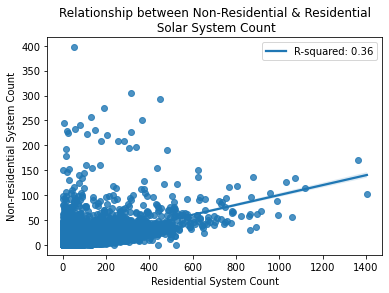

In [6]:
#Examine relationship between residential and non-residential solar system counts
regression_scatter(df['solar_system_count_residential'], df['solar_system_count_nonresidential'],
                   'Residential System Count', 'Non-residential System Count', 
                  'Relationship between Non-Residential & Residential\n Solar System Count')

In [7]:
#Confirm that the target variable is not missing any values
len(df[df['solar_system_count_residential'].isna()])

0

In [8]:
#Examine the spread of the target variables
df['solar_system_count_residential'].describe()

count    72537.000000
mean        17.615755
std         48.970994
min          0.000000
25%          0.000000
50%          3.000000
75%         12.000000
max       1404.000000
Name: solar_system_count_residential, dtype: float64

In [9]:
#View percent of rows that have a value for residential solar system count
len(df[df['solar_system_count_residential']>0])/len(df)

0.7379544232598536

## Data Type Correction
Random Forest, XGBoost, and Neural Networks do not accept categorical features. Therefore, these features needed to be encoded, potentially through one-hot encoding or label encoding. Features in the dataset that were non-numeric were identified and converted through various methods. 

In [10]:
#Print list of categorical columns so they can be examined to see if they should be converted to float or
#encoded in a different way
cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
cat_cols

['county',
 'state',
 'electricity_price_transportation',
 'voting_2016_dem_win',
 'voting_2012_dem_win']

In [13]:
#Convert electricity_price_transportation to float - it is clearly numeric and was simply read in incorrectly
df['electricity_price_transportation'].value_counts().head(10)
df['electricity_price_transportation'] = pd.to_numeric(df['electricity_price_transportation'],errors='coerce')

8.99     8056
5.34     5265
12.95    4918
8.92     4245
7.82     3218
6.81     3123
7.69     2952
11.44    2813
7.90     2195
10.25    2010
Name: electricity_price_transportation, dtype: int64

In [14]:
#voting values are either false/true, encode these with binary 0/1 instead
df['voting_2016_dem_win'].value_counts()
df['voting_2016_dem_win'] = np.where(df['voting_2016_dem_win'] == True, 1, 
                                    np.where(df['voting_2016_dem_win'] == False, 0, -1))

True     39177
False    33360
Name: voting_2016_dem_win, dtype: int64

In [15]:
#voting values are either false/true, encode these with binary 0/1 instead
df['voting_2012_dem_win'].value_counts()
df['voting_2012_dem_win'] = np.where(df['voting_2012_dem_win'] == True, 1, 
                                    np.where(df['voting_2012_dem_win'] == False, 0, -1))

False    36986
True     35551
Name: voting_2012_dem_win, dtype: int64

In [16]:
#define the target variable
target_var = 'solar_system_count_residential'
#Define variables that may potentially provide additional information about the target variable. Will need
#to remove these look ahead variables so the model is not cheating when it makes its predictions
look_ahead_vars = ['tile_count', 'solar_system_count', 'tile_count_residential', 'tile_count_nonresidential',
                  'solar_system_count_residential', 'solar_system_count_nonresidential', 'total_panel_area',
                   'total_panel_area_residential', 'total_panel_area_nonresidential',
                   'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita',
                   'number_of_solar_system_per_household']

look_ahead_vars.remove(target_var)
df = df.drop(look_ahead_vars, axis=1)

#Separate data into x and y
x = df[df.columns.difference([target_var])]
y = df[target_var]

#Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

train_data = pd.concat([x_train, pd.DataFrame(y_train.values, columns = [target_var], index = y_train.index)], axis=1)
train_data.head()

test_data = pd.concat([x_test, pd.DataFrame(y_test.values, columns = [target_var], index = y_test.index)], axis=1)


,age_10_14_rate,age_15_17_rate,age_18_24_rate,age_25_34_rate,age_35_44_rate,age_45_54_rate,age_55_64_rate,age_5_9_rate,age_65_74_rate,age_75_84_rate,age_median,age_more_than_85_rate,air_temperature,atmospheric_pressure,average_household_income,average_household_size,avg_electricity_retail_rate,cooling_degree_days,cooling_design_temperature,cooperate_tax,county,daily_solar_radiation,diversity,dropout_16_19_inschool_rate,earth_temperature,earth_temperature_amplitude,education_bachelor,education_bachelor_rate,education_college,education_college_rate,education_doctoral,education_doctoral_rate,education_high_school_graduate,education_high_school_graduate_rate,education_less_than_high_school,education_less_than_high_school_rate,education_master,education_master_rate,education_population,education_professional_school,education_professional_school_rate,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_residential,electricity_consume_total,electricity_price_commercial,electricity_price_industrial,electricity_price_overall,electricity_price_residential,electricity_price_transportation,elevation,employ_rate,employed,feedin_tariff,fips,frost_days,gini_index,health_insurance_none_rate,health_insurance_public_rate,heating_degree_days,heating_design_temperature,heating_fuel_coal_coke,heating_fuel_coal_coke_rate,heating_fuel_electricity,heating_fuel_electricity_rate,heating_fuel_fuel_oil_kerosene,heating_fuel_fuel_oil_kerosene_rate,heating_fuel_gas,heating_fuel_gas_rate,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_none_rate,heating_fuel_other,heating_fuel_other_rate,heating_fuel_solar,heating_fuel_solar_rate,household_count,household_type_family_rate,housing_unit_count,housing_unit_median_gross_rent,housing_unit_median_value,housing_unit_occupied_count,incentive_count_nonresidential,incentive_count_residential,incentive_nonresidential_state_level,incentive_residential_state_level,land_area,lat,lon,median_household_income,mortgage_with_rate,net_metering,number_of_years_of_education,occupancy_owner_rate,occupancy_vacant_rate,occupation_administrative_rate,occupation_agriculture_rate,occupation_arts_rate,occupation_construction_rate,occupation_education_rate,occupation_finance_rate,occupation_information_rate,occupation_manufacturing_rate,occupation_public_rate,occupation_retail_rate,occupation_transportation_rate,occupation_wholesale_rate,per_capita_income,population,population_density,poverty_family_below_poverty_level,poverty_family_below_poverty_level_rate,poverty_family_count,property_tax,race_asian,race_asian_rate,race_black_africa,race_black_africa_rate,race_indian_alaska,race_indian_alaska_rate,race_islander,race_islander_rate,race_other,race_other_rate,race_two_more,race_two_more_rate,race_white,race_white_rate,rebate,relative_humidity,sales_tax,state,total_area,transportation_bicycle_rate,transportation_car_alone_rate,transportation_carpool_rate,transportation_home_rate,transportation_motorcycle_rate,transportation_public_rate,transportation_walk_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,travel_time_average,travel_time_less_than_10_rate,unemployed,voting_2012_dem_percentage,voting_2012_dem_win,voting_2012_gop_percentage,voting_2016_dem_percentage,voting_2016_dem_win,voting_2016_gop_percentage,water_area,wind_speed,solar_system_count_residential
40203,0.048618,0.033937,0.101430,0.188942,0.110010,0.142612,0.108866,0.060248,0.074357,0.043661,34.1,0.009724,8.6,96.6,62875.045454,2.33,7.25,659.0,21.96,0,Pierce County,3.35,0.501541,0.942584,9.0,14.81,678,0.190610,1162,0.326680,33,0.009277,1149,0.323025,184,0.051729,328,0.092213,3557,23,0.006466,6680,76502,964,84146,8.22,4.35,7.40,9.09,8.18,433.0,0.925342,2640,11,53053072312,70.0,0.4223,0.096142,0.384965,3430.0,-2.52,19,0.008636,1579,0.717727,0,0.000000,602,0.273636,2200,0,0.000000,0,0.000000,0,0.000000,2200,0.614091,2384,835.0,254300.0,2200,30,23,11,8,0.953812,47.206

## Missing Values Imputation
The data was explored to identify columns with missing values to determine how best to impute them. Imputation is important for machine learning models because certain machine learning models, such as neural networks, need a complete dataset. Simply removing the columns or rows with missing data would reduce the training data size and potentially impact model performance and introduce bias in to the model.<sup>6</sup>

In [18]:
#Find columns with missing values
na_cols = find_na_columns(df)
na_cols[0:10]

['average_household_income',
 'gini_index',
 'land_area',
 'per_capita_income',
 'population_density',
 'total_area',
 'water_area',
 'education_less_than_high_school_rate',
 'education_high_school_graduate_rate',
 'education_college_rate']

There were 103 columns that contained missing values. There are several methods for imputation of missing values. Some examples include zero, mean, and median imputation. Zero imputation would add bias and skew some of the columns like median household income, total area, and education rate. Additionally, many of the columns with missing values had large or small outliers that would effect mean imputation. Therefore, median imputation was implemented. The county level median value, established using the training dataset only, was used to impute missing values for each column. In this way the imputed rows would be within the range of other land areas in the same county. Only the training dataset was used to establish the imputation value so there was no data leakage into the testing dataset.

In [19]:
#Impute columns with missing values using county level medians
for col in na_cols:
    train_data, test_data = impute_values(train_data, test_data, col,'county', 'median')

In [20]:
#Check to see if there any any columns remaining with missing values
na_cols = find_na_columns(train_data)
na_cols[1:10]

['atmospheric_pressure',
 'cooling_degree_days',
 'cooling_design_temperature',
 'daily_solar_radiation',
 'dropout_16_19_inschool_rate',
 'earth_temperature',
 'earth_temperature_amplitude',
 'electricity_price_transportation',
 'elevation']

There were still some variables that had missing values even after this imputation was completed. Most of the remaining variables were missing less than 10 rows; however, transportation electricity price 2012 democratic voting percentage, and 2012 GOP voting percentage were missing almost 5,000 rows. 

In [21]:
#Check the number of missing rows for each column. I will remove those columns with a signficant amount of 
#rows missing
for col in na_cols:
    if len(train_data[train_data[col].isna()]) > 10:
        print(col, ' has ', len(train_data[train_data[col].isna()]), ' missing')

electricity_price_transportation  has  4302  missing
voting_2012_dem_percentage  has  4902  missing
voting_2012_gop_percentage  has  4902  missing


These columns were dropped from the dataset and then any remaining rows that had missing values in other columns were dropped. 

In [22]:
#Drop the columns that had almost 5,000 rows of missing data.
drop_cols = ['electricity_price_transportation','voting_2012_dem_percentage','voting_2012_gop_percentage']
train_data = train_data.drop(drop_cols, axis=1)
test_data = test_data.drop(drop_cols, axis=1)

In [23]:
#Drop any remaining rows with n/a values
train_data = train_data.dropna()
len(train_data)
test_data = test_data.dropna()
len(test_data)

58018

14502

Lastly, columns that were likely to be uninformative in the model were dropped, such as FIPS, state, and county. These features provide granular information about the rows of data, but do not help to assess the larger trend in solar panel adoption.

In [24]:
#Drop variables that are uninformative for the target variable
uninformative_vars = ['fips', 'county', 'state'] #'lat', 'lon'
train_data = train_data.drop(uninformative_vars, axis=1)
test_data = test_data.drop(uninformative_vars, axis=1)

## Remove Correlated Features
The next step in the data cleaning process was to remove correlated variables. Removal of correlated features is important because some machine learning models, such as Random Forest, become unstable in the presence of highly correlated features. Moreover, the feature importances of correlated features would be decreased as the importance would be shared across several features rather than attributed to the actual driver of the information. This could lead to incorrect interpretation of the model.<sup>7</sup>

In [25]:
#Remove features that are correlated above 0.8 with another feature. Perform removal in a step-wise fashion, 
#removing one feature that is least correlated with the target variable at each iteration until all features have 
#correlation values below 0.8
train_data, dropped_cols = remove_correlation(train_data, target_var)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
#Drop these features from the test set (they were already dropped from the train set)
test_data = test_data.drop(dropped_cols, axis=1)

## Noramlize/Standardize Data
The distribution of the remaining variables in the dataset were examined to determine the best way to normalize them. Normalization of the data is important so that all features are on a similar scale and follow a Gaussian distribution.

The MinMaxScaler, StandardScaler, and PowerTransformer functions were compared. The MinMaxScaler function scales the data to its range by subtracting the minimum from each value and dividing by the maximum minus the minimum for the column. The StandardScaler function scales the data by standardizing it by subtracting the mean and dividing by the standard deviation. After standardization, the data will have a mean of 0 and a standard deviation of 1. The PowerTransformer is a form of logarithmic transformation that can also handle cases where the data is zero.<sup>8</sup> From the histograms of the variables, it was seen that the power transformation on the variables did the best job of removing skewness and standardizing the scale for the variables. 

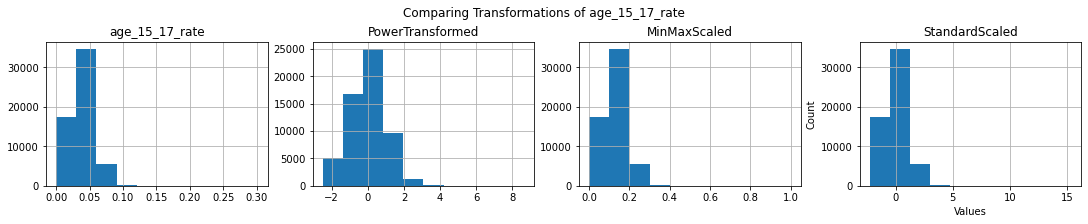

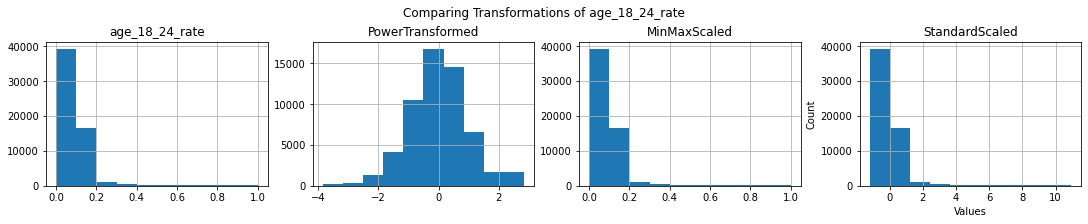

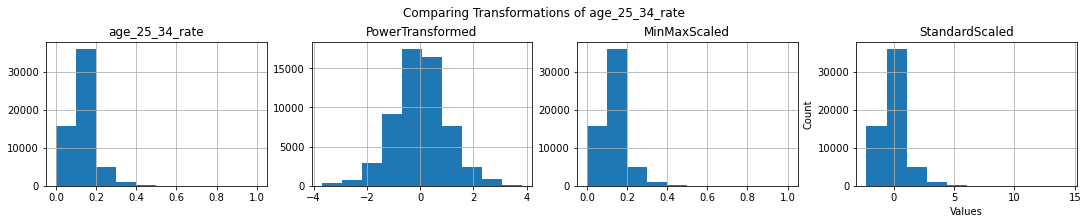

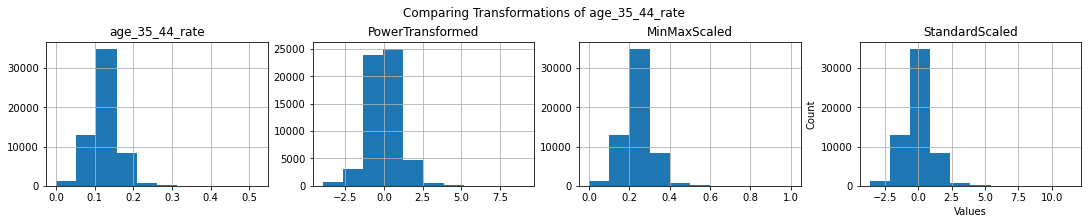

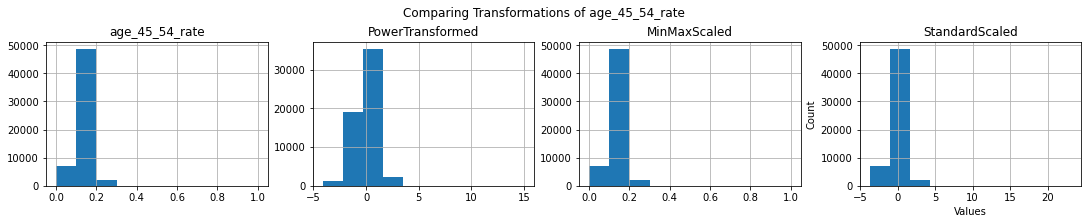

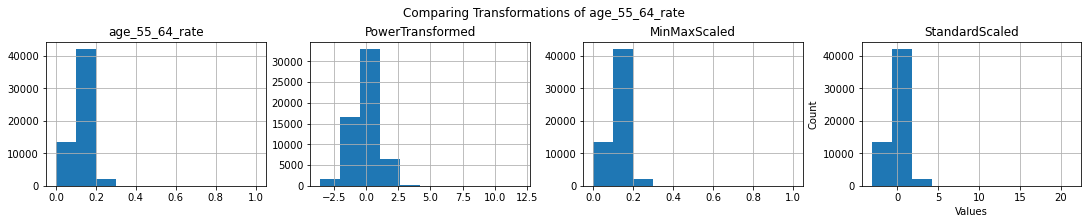

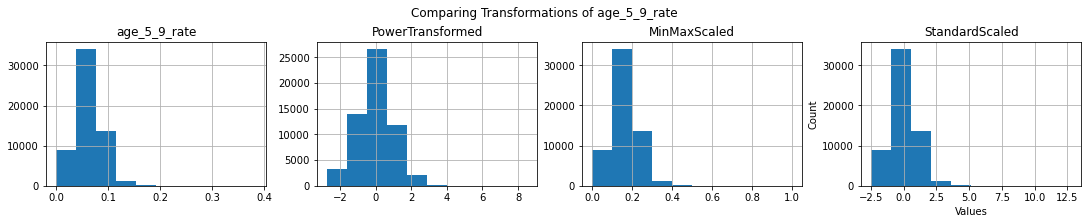

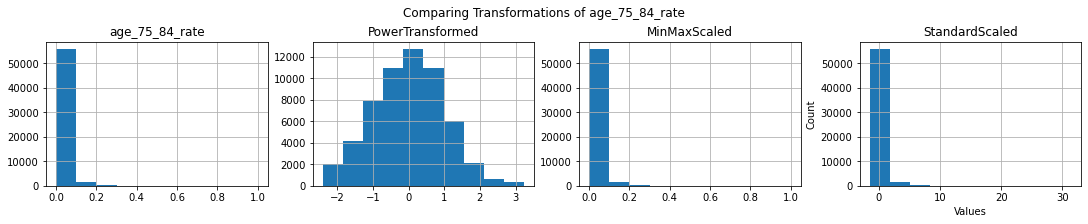

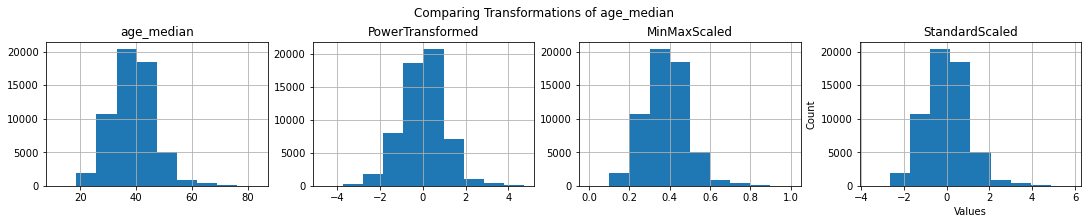

In [27]:
#Investigate distribution of values for numeric columns - determine type of transformation to fix scewness and 
#scale discrepencies in the data
no_plot = list()
for col in list(train_data.select_dtypes(include=[np.number]).columns.values)[1:10]:
    #Only 10 columns plotted to save space in output notebook. Full data analysis included a comparison of all features.
    try:
        transformation_comparison(train_data, col)
    except:
        no_plot.append(col)
        continue

In [28]:
train_data = train_data.drop(['PowerTransformed', 'MinMaxScaled', 'StandardScaled'], axis=1)

Through inspection of several of the variables, it was seen that the Box-Cox method performed better than the Yeo-Johnson method to power transform the variables to have a more Gaussian distribution.

In [30]:
#Examine power transformer methods: box-cox vs. yeo-johnson
# for col in train_data.columns:
#     if train_data[col].min() > 0:
#         print(col)
# pt = PowerTransformer('box-cox')
# pt2 = PowerTransformer('yeo-johnson')
# fig, axes = plt.subplots(1,2, figsize=(10,3), constrained_layout=True)
# _ = fig.suptitle('Comparing Power Transformation Methods on Housing Unit Median Value')
# train_data[["Box_Cox"]] = pd.DataFrame(pt.fit_transform(train_data[['median_household_income']]), columns=['median_household_income'])
# _ = train_data.hist('Box_Cox', ax = axes[0])
# train_data[["Yeo_Johnson"]] = pd.DataFrame(pt2.fit_transform(train_data[['median_household_income']]), columns=['median_household_income'])
# _ = train_data.hist('Yeo_Johnson', ax = axes[1])
# _ = plt.show()
# train_data.drop(["Box_Cox", "Yeo_Johnson"], axis=1)

The Box-Cox method uses maximum likelihood estimation to determine the ideal power transformation on the variable and only works on positive values. The Yeo-Johnson method also uses maximum likelihood estimation to determine the ideal power transformation, but it can handle zero and negative values.<sup>9</sup>
Taking this into account, all variables that were strictly positive were transformed using the Box-Cox method. All other variables were transformed using the Yeo-Johnson method. The power transformer was fit to the training data alone so as to avoid data leakage in the testing data. After the fit, both the training and testing datasets were transformed with the power transformer. As a result, all features were on similar scales and had more Gaussian distributions.

In [29]:
#Use Box-Cox transformation on strictly positive variables and Yeo-Johnson on other columns
numeric_cols = list(train_data.select_dtypes(include=[np.number]).columns.values)
pos_cols = [col for col in numeric_cols if train_data[col].min() > 0 and test_data[col].min() > 0 and col not in no_plot]
nonpos_cols = [col for col in numeric_cols if col not in pos_cols and col not in no_plot and col != target_var]

#Use box-cox method to transform positive columns
pt = PowerTransformer('box-cox')
print(pt.fit(train_data[pos_cols]))
train_data[pos_cols] = pt.transform(train_data[pos_cols])
test_data[pos_cols] = pt.transform(test_data[pos_cols])

#Use yeo-johnson method to transform columns with negative values
pt2 = PowerTransformer('yeo-johnson')
print(pt2.fit(train_data[nonpos_cols]))
train_data[nonpos_cols] = pt2.transform(train_data[nonpos_cols])
test_data[nonpos_cols] = pt2.transform(test_data[nonpos_cols])

PowerTransformer(method='box-cox')
PowerTransformer()


In [30]:
#Split data into data and labels for model training
target_var = 'solar_system_count_residential'
train_labels = train_data[target_var]
train_data = train_data[train_data.columns.difference([target_var])]
test_labels = test_data[target_var]
test_data = test_data[test_data.columns.difference([target_var])]

# Model Creation
Three different modeling methods, Random Forest, XGBoost and a Neural Network, were used to predict each target variable. The goal was to identify the best model for each target variable and hyperparameter tune that model to achieve the optimal performance for predictive accuracy. 

## Random Forest Model
The first model attempted was Random Forest. Radom Forest is an ensemble method that uses a combination of decision trees to create a more robust model.<sup>10</sup> Decision trees are weak learners that are subject to large variance and bias.11 Random Forest is a bagging algorithm. This means that the algorithm fits many decision trees to sampled versions of the training data and creates its final regression by taking the majority vote or average from the trees. The objective function used to train the model was mean-squared error (MSE). 

### Default Model
To establish a baseline for the Random Forest model, the data was passed through with the default settings.

In [53]:
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':1000,
              'criterion':'squared_error', #equivalent to MSE
             }

model = RandomForestRegressor(**params_rfr)

In [54]:
%%time
model.fit(train_data, train_labels)

CPU times: user 1h 29min 57s, sys: 60 s, total: 1h 30min 57s
Wall time: 1h 32min 27s


RandomForestRegressor(n_estimators=1000)

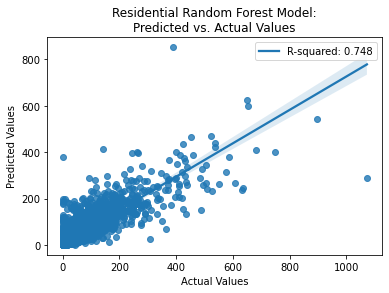

<Figure size 432x288 with 0 Axes>

In [55]:
test_predictions = model.predict(test_data)

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Residential Random Forest Model:\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/rf_residential_system_count_errors_default')


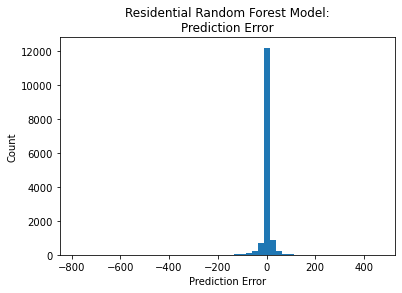

In [58]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Residential Random Forest Model:\nPrediction Error')

In [57]:
mse = mean_squared_error(test_labels, test_predictions)
print(f'the mse is {mse}')

the mse is 552.287959087781


The feature importance for the Random Forest model is shown below. The feature importance is an attribute of the model and measures the mean and standard deviation of accumulation of the impurity decrease within each tree.<sup>8</sup>

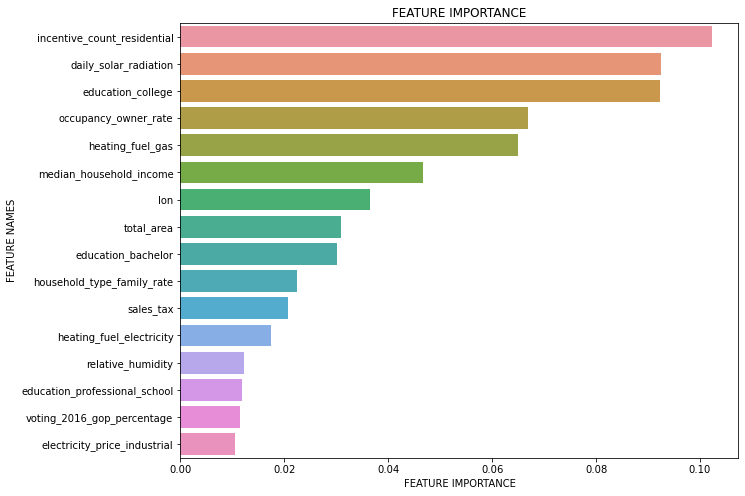

In [59]:
fi_rf = plot_feature_importance(model.feature_importances_, train_data.columns)

### Tuned Model
Hyperparameter tuning was completed to attempt to improve the model performance. Various settings for number of estimators (n_estimators), maximum features to consider when splitting trees (max_features), maximum tree depth (max_depth), minimum number of samples on which to split (min_samples_split), minimum samples for each leaf (min_samples_leaf), and bootstrapping (boostrap) were compared through a randomized search with 5 cross-validations.

In [31]:
model = RandomForestRegressor()

parameters = {'criterion':['squared_error'],
              'n_estimators': [300,500,600, 1000],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [7,10,20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5],
              'bootstrap': [True, False]}
random_search = RandomizedSearchCV(estimator=model, param_distributions=parameters,
                                           n_iter=50, cv=5, verbose=3, random_state=seed,
                                           n_jobs=-1, scoring = 'neg_mean_absolute_error')
random_search.fit(train_data, train_labels)


In [119]:
random_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'squared_error',
 'bootstrap': False}

In [60]:
params_rfr = {'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'squared_error',
 'bootstrap': False}
model = RandomForestRegressor(**params_rfr)

In [61]:
%%time
model.fit(train_data, train_labels)

CPU times: user 9min 51s, sys: 5.02 s, total: 9min 56s
Wall time: 10min 5s


RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=5, min_samples_split=5,
                      n_estimators=1000)

In [62]:
mse = mean_squared_error(test_labels, test_predictions)
print(f'the mse is {mse}')

the mse is 552.287959087781


From the plot below, it seems that college education, daily solar radiation, and heating fuel gas are the most informative features in the model. These features account for almost 15% of the information gain.

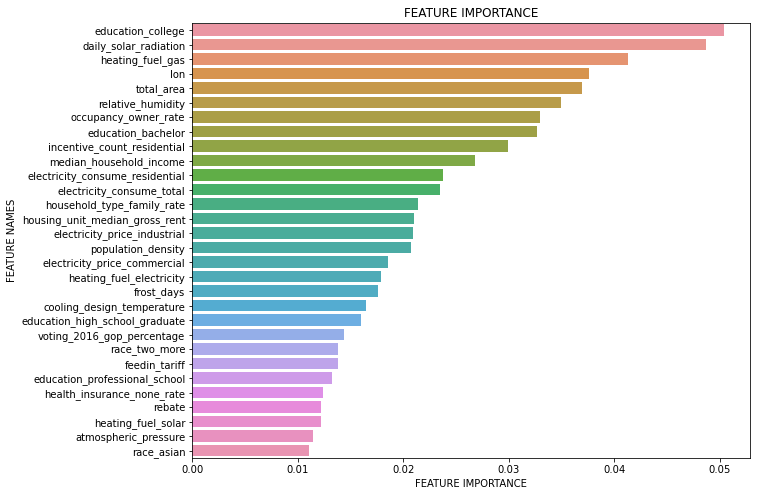

In [64]:
fi_rf = plot_feature_importance(model.feature_importances_, train_data.columns)

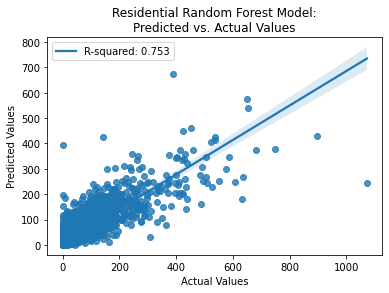

<Figure size 432x288 with 0 Axes>

In [65]:
test_predictions = model.predict(test_data)

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Residential Random Forest Model:\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/rf_residential_system_count_errors_tuned')


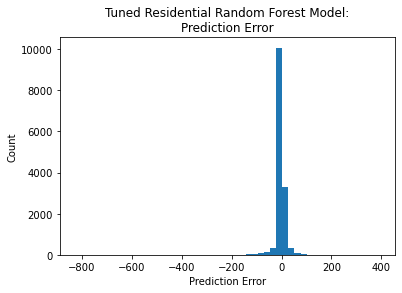

In [66]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Tuned Residential Random Forest Model:\nPrediction Error')

## XGBoost Model
The next model attempted was XGBoost. XGBoost is an ensemble method that combines multiple decision trees with gradient boosting. XGBoost sequentially fits decision trees based on the previous tree’s residual errors to essentially average over the decision tree results and minimize the loss function and error of the model.<sup>12</sup>

### Default Model
The model for the residential solar system was initially trained using 1,000 estimators with a learning rate of 0.01 and all other default settings. 

In [39]:
# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              'n_estimators': 1000,  # number of trees to use
              'learning_rate': 0.01, 
             }

In [40]:
#Setup the model
model = XGBRegressor(**params_xgb)

In [41]:
#Fit the model and record time
%%time
model.fit(train_data, train_labels)

CPU times: user 24min 16s, sys: 3.91 s, total: 24min 20s
Wall time: 3min 5s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

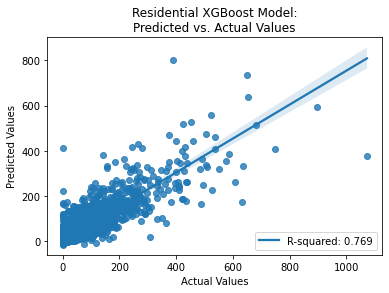

In [42]:
#Output scatterplot of predicted vs. actual values
test_predictions = model.predict(test_data)
regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Residential XGBoost Model:\nPredicted vs. Actual Values')#,
#                   '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/xgboost_residential_system_count_errors_default')


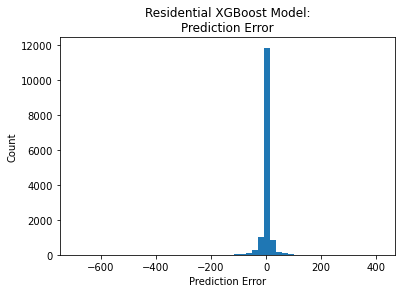

In [43]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Residential XGBoost Model:\nPrediction Error')
#plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_residential_system_count_errors_hist_default.png")

In [44]:
#Retrieve MSE score for the model
mse = round(mean_squared_error(test_labels, test_predictions))
print(f'the mse is {mse}')

the mse is 503


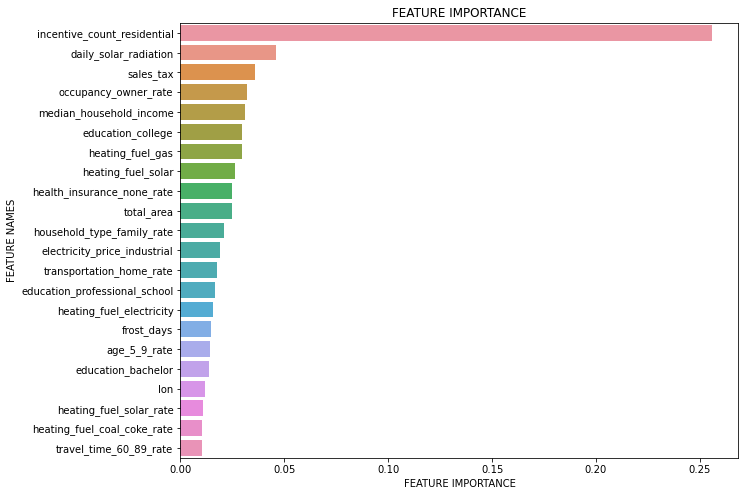

In [45]:
#Plot feature importances for model
fi_xgboost = plot_feature_importance(model.feature_importances_, train_data.columns)

#plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_residential_system_count_feature_importance_default.png")

In [50]:
#Save model
# pickle.dump(model, open('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/models/residential/xgboost_residential_solar_system_count.sav', 'wb'))


In [68]:
#load saved model
#loaded_model = pickle.load(open('/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/models/residential/xgboost_residential.sav', 'rb'))
# plot_feature_importance(loaded_model.feature_importances_, train_data.columns)

### Tuned Model
To see if it was possible to improve model performance, hyperparameter tuning was implemented using a randomized search over various parameter settings. 

In [32]:
model = XGBRegressor()
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [.01, 0.1], 
              'max_depth': [7,10,20],
              'min_child_weight': [1, 10 ,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,500,600, 1000],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [0, 2,3,5],
              "gamma"       : [0, 1 ,3]}
random_search = RandomizedSearchCV(estimator=model, param_distributions=parameters,
                                           n_iter=100, cv=5, verbose=3, random_state=seed,
                                           n_jobs=-1, scoring = 'neg_mean_absolute_error')
random_search.fit(train_data, train_labels)


In [59]:
random_search.best_params_

{'reg_lambda': 2,
 'reg_alpha': 0.2,
 'objective': 'reg:squarederror',
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 20,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 0.8,
 'booster': 'gbtree'}

The settings included two new regularization terms: lambda and alpha. These regularization terms help to adjust the model for overfitting and try to remove model complexity by adding a term to tamper the weights of the input features.\
Lambda regularization is also called L2 regularization or ridge regression. L2 regularization penalizes the sum of square weights and forces them to be small, but not zero. Alpha regularization corresponds to L1 regularization or lasso regression. L1 regularization shrinks parameters towards zero by minimizing their weights.<sup>13</sup>

In [46]:
#Run XGBoost model with tuned hyperparameters
params_xgb = {'reg_lambda': 2,
 'reg_alpha': 0.2,
 'objective': 'reg:squarederror',
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 20,
 'learning_rate': 0.01,
 'gamma': 0,
 'colsample_bytree': 0.8,
 'booster': 'gbtree'}
model = XGBRegressor(**params_xgb)

In [47]:
%%time
model.fit(train_data, train_labels)

CPU times: user 22min 20s, sys: 10.4 s, total: 22min 31s
Wall time: 3min 3s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=20, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.2, reg_lambda=2, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

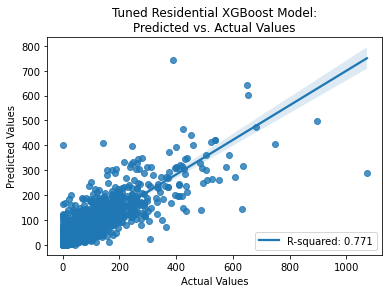

In [48]:
test_predictions = model.predict(test_data)
regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Tuned Residential XGBoost Model:\nPredicted vs. Actual Values')#,
#                   "/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_residential_system_count_errors_tuned")

In [49]:
mse = round(mean_squared_error(test_labels, test_predictions))
print(f'the mse is {mse}')

the mse is 514


From the plot below, it appears that the number of residential incentives was by far the most important feature in the XGBoost model, accounting for almost 40% of the information gain. Daily solar radiation, industrial electricity price, sales tax, and residential electricity consumption were the next most important features, all accounting for ~10% of the information gain in the model.

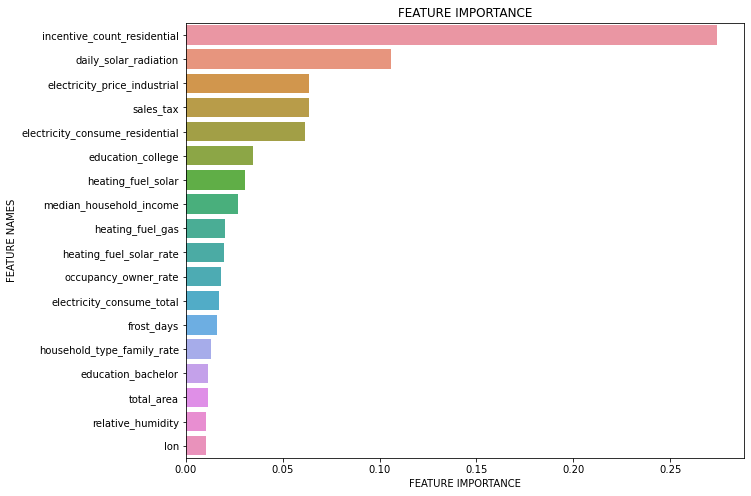

In [50]:
fi_xgboost = plot_feature_importance(model.feature_importances_, train_data.columns)

# plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_residential_tuned_system_count_feature_importance.png")

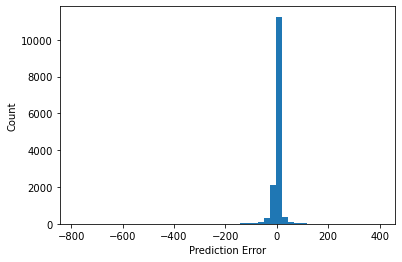

In [51]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Tuned Residential XGBoost Model:\nPrediction Error')
#plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_residential_tuned_system_count_errors_hist.png")

The features were also evaluated using Shapley values, which is a method based on game theory to determine how much contribution of information can be attributed to each feature.<sup>14</sup> The Shapley analysis also attributes high importance to daily solar radiation and residential incentive count, which both are positively correlated with the target, as shown by the high feature values corresponding with high positive impact on the model output.

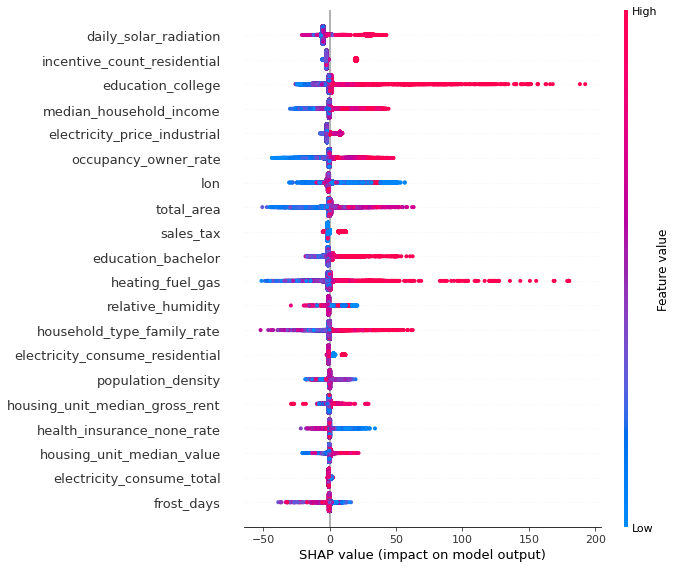

<Figure size 432x288 with 0 Axes>

In [68]:
#Examine Shapley values as another form of feature importance evaluation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_data, approximate=True)
shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns)

plt.savefig("/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/plots/xgboost_residential_tuned_system_count_shap.png")

# Neural Network Regression
Lastly, a neural network was built. Initially the neural network was setup as a single layer with 128 perceptrons. Each perceptron takes the sum of all inputs and their weights and applies a non- linear activation function to determine the output.<sup>15</sup>

The weights for each input are resolved through gradient descent and back propagation using the Chain Rule to multiply derivates. A non-linear rectified linear unit (ReLU) activation function was added to the layer so the model could identify complex relationships between the features. There are several common activation functions used in neural networks, including the sigmoid function, hyperbolic tangent, and ReLU. This model used the ReLU function in order to avoid the issue of the vanishing gradient.<sup>15</sup>

The model also incorporated an Adam optimizer to dynamically adapt and optimize the learning rate for the model so as to avoid local minima. Lastly, early stopping was employed to prevent overfitting in the models.

### Single Layer Neural Network
The model was initially established as a single layer neural network.

In [105]:
# Define basic architecture - code from Pierre Gentine - ML for Environmental Engineering
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define the optimizer 
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 13,441
Trainable params: 13,441
Non-trainable params: 0
_________________________________________________________________



...................................................................

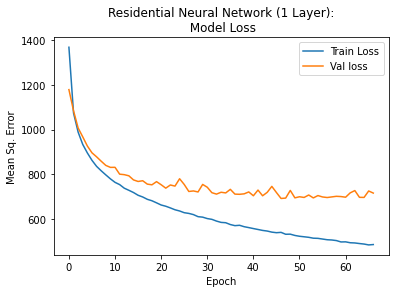

In [107]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history, 'Residential Neural Network (1 Layer):\n Model Loss')

In [70]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:     681


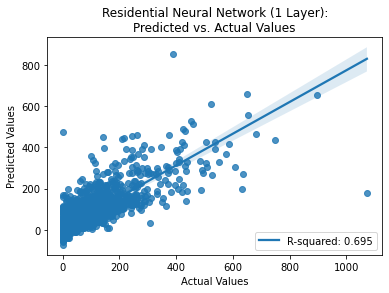

<Figure size 432x288 with 0 Axes>

In [71]:
test_predictions = model.predict(test_data).flatten()

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Residential Neural Network (1 Layer):\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/nn_residential_system_count_errors_1L')


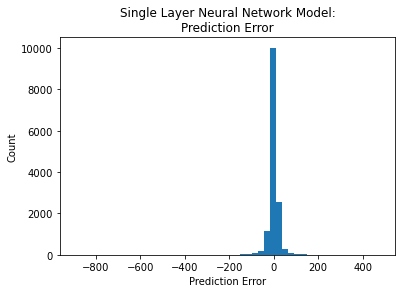

In [72]:
# histogram
error = test_predictions - test_labels
_ = plt.hist(error, bins = 50)
_ = plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
_ = plt.title('Single Layer Neural Network Model:\nPrediction Error')

### 3 Layer Neural Network
To try to improve model performance, additional hidden layers were added to the neural network. All of the hidden layers had a ReLU activation function and 128 units.

In [38]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3',),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________


2021-12-21 22:48:17.139255: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-12-21 22:49:10.313713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)



....................................

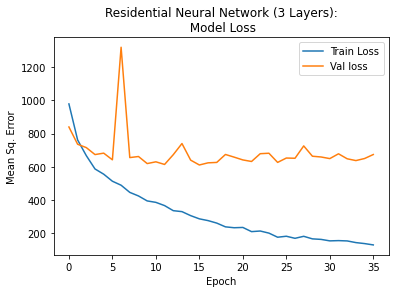

In [41]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history,'Residential Neural Network (3 Layers):\n Model Loss' )

The loss plot for this neural network indicates some overfitting occurred because the training loss and validation loss diverged quickly at around 3 epochs.

In [42]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:     616


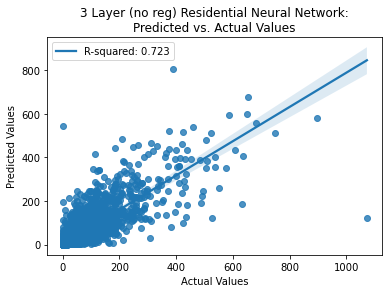

<Figure size 432x288 with 0 Axes>

In [43]:
test_predictions = model.predict(test_data).flatten()

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   '3 Layer (no reg) Residential Neural Network:\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/nn_residential_system_count_errors_1L')


### 3 Layer Neural Network with Regularization
L2-Regularization was added in the 2nd hidden layer to try to account for overfitting in the previous model.

In [77]:
#reg_alpha=0.2, reg_lambda=2
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2',kernel_regularizer=tf.keras.regularizers.L2(2.)),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3'),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________



................................................................

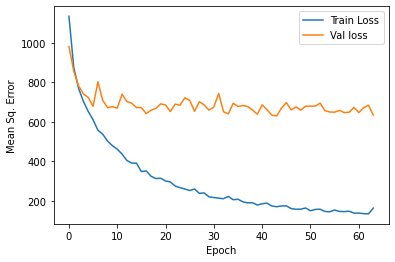

In [78]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

Overfitting is still seen in the plot of the MSE for this model.

In [79]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:     606


### 3 Layer Neural Network with Dropout
Next, dropout was added to try to tackle the overfitting from another angle. A dropout parameter of 50% was added between the first and second hidden layers.

In [56]:
#regularizers.l1_l2(l1=1e-5, l2=1e-4)

#reg_alpha=0.2, reg_lambda=2
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(train_data.shape[1],),
                       name='hidden_layer_1'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_2'),
    keras.layers.Dense(128, activation=tf.nn.relu,
                       name='hidden_layer_3'),
    keras.layers.Dense(1, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.optimizers.Adam()

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=tf.keras.metrics.MeanSquaredError())

# show a summary of the data
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 128)               13312     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               16512     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               16512     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 46,465
Trainable params: 46,465
Non-trainable params: 0
_________________________________________________________________



.................................................

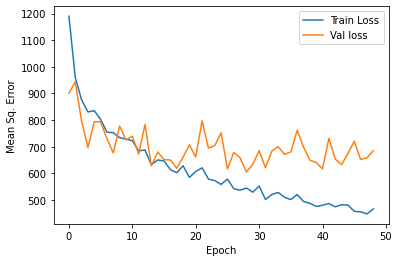

In [57]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history, 'Residential Neural Network (w/ dropout):\nModel Loss')

The plot of MSE shows a lot less overfitting in the model.

In [58]:
[loss, mse] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Sq. Error: {:7.0f}".format(mse))

Testing set Mean Sq. Error:     626


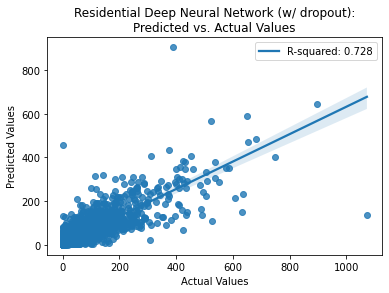

<Figure size 432x288 with 0 Axes>

In [61]:
test_predictions = model.predict(test_data).flatten()

regression_scatter(test_labels, test_predictions, 'Actual Values', 'Predicted Values',
                   'Residential Deep Neural Network (w/ dropout):\nPredicted vs. Actual Values',
                  '/Users/gabbynyirjesy/Documents/ML for Env Engineering/Solar-Panel-Area-Prediction/deep_nn_residential_system_count_errors')


In [64]:
explainer = shap.KernelExplainer(model.predict,shap.sample(train_data, 100))

In [33]:
shap_values = explainer.shap_values(shap.sample(train_data,100), approximate=True)

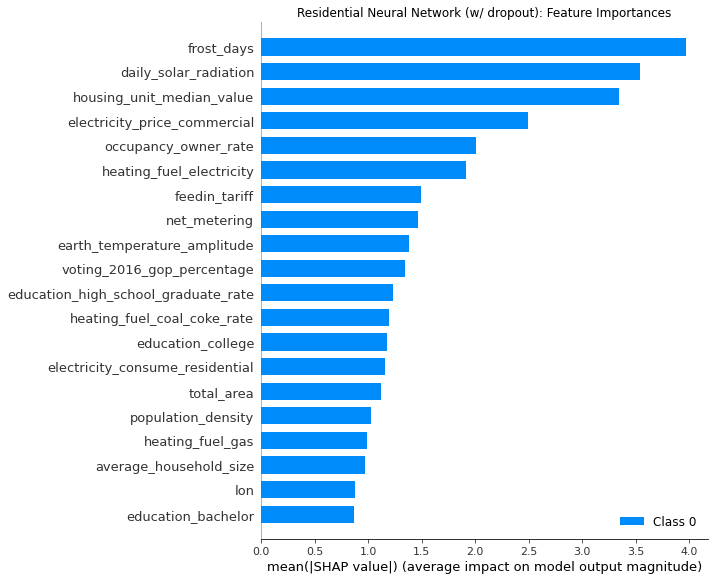

In [66]:
_ = shap.summary_plot(shap_values, features=train_data, feature_names=train_data.columns,show=False)
_ = plt.title('Residential Neural Network (w/ dropout): Feature Importances')
_ = plt.show()

The Shapley values for the model with dropout were assessed and showed that frost days, daily solar radiation, and housing unit median value were the most important predictive features.

# Conclusion
The best performing residential model was XGBoost. This model had an MSE of 503 and R2 value for the predictions vs. actual values of 0.769. The top important features in this model were residential incentive count, daily solar radiation, and college education.

The models could be implemented to identify areas likely to have a large amount of residential solar systems and work to establish the sales pipeline in those locations. Additionally, from the residential model it is seen that the number of residential incentives are highly correlated with the number of solar systems in a county. This information could be used to convince politicians to add more incentives to promote solar power adoption at the residential level.